In [1]:
import matplotlib.pyplot as plt
from snaptools import plot_tools
import numpy as np

from mpl_toolkits.axes_grid1 import Grid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Ellipse
import h5py
import matplotlib.gridspec as gridspec
import conversions as co
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import ImageGrid
from snaptools import utils
from snaptools import snapio
from snaptools import CBcm
from snaptools import manipulate
from snaptools import simulation
from functools import partial
from scipy import ndimage
from scipy import stats
from scipy.ndimage import measurements as measure

%matplotlib inline
%load_ext autoreload
%autoreload 2
colors = ['#332288', '#CC6677', '#6699CC', '#117733']
import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('lines', linewidth=3)

/usr/users/spardy/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
HernOffsets_new = h5py.File('../Data/offSetsHern_new.hdf5', 'r')
DehnenOffsets_new = h5py.File('../Data/offSetsDehnen_new.hdf5', 'r')

HernOffsets_continue = h5py.File('../Data/offSetsHern_continue.hdf5', 'r')
DehnenOffsets_continue = h5py.File('../Data/offSetsDehnen_continue.hdf5', 'r')

In [3]:
dynamical_centers = DehnenOffsets_new['/stars/45deg/main/dynamical_center'][:]

In [4]:
IC_dyn_centers = DehnenOffsets_new['stars/IC/dynamical_center'][:]

In [8]:
ICfolder = "/usr/users/spardy/coors2/working/Dehnen_LMC/" +\
         "stars2gas/output_stars2gas/"

In [9]:
folder = "/usr/users/spardy/coors2/working/Dehnen_LMC/" +\
         "collisions_best/output_Dehnen_smc_45deg/"

In [10]:
cont_folder = "/usr/users/spardy/coors2/working/Dehnen_LMC/" +\
             "collisions_best/Dehnen_smc_45deg_continue/output_Dehnen_smc_45deg/"

In [7]:
sim = simulation.Simulation(folder)
ICsim = simulation.Simulation(ICfolder)

In [149]:
snapnum = 12
snap = snapio.load_snap(folder+"snap_{:03d}".format(snapnum))
snap.set_settings(first_only=True,
                 com=True,
                 xlen=10,
                 ylen=10,
                 NBINS=256,
                 in_min=-0.2752,
                 parttype='stars',
                 halo_center_method='tree_halo',
                 log_scale=False)
com1, com2, idgal1, idgal2 = snap.center_of_mass('stars')
xc = dynamical_centers[snapnum, 0] 
yc = dynamical_centers[snapnum, 1] 
zc = dynamical_centers[snapnum, 2] 

In [150]:
r = np.sort(np.sqrt(np.sum( (snap.pos['stars'][idgal1, :] - com1 - dynamical_centers[0, :])**2, axis=1)))

## Concentration

In [151]:
pmf = np.cumsum(r)
tot_light = np.sum(r)
where_80perc = np.argmin(np.abs(pmf - 0.8*tot_light))
where_20perc = np.argmin(np.abs(pmf - 0.2*tot_light))
c = 5.0*np.log10(r[where_80perc]/r[where_20perc])
print "Concentration C = {:g}".format(c)

Concentration C = 2.22068


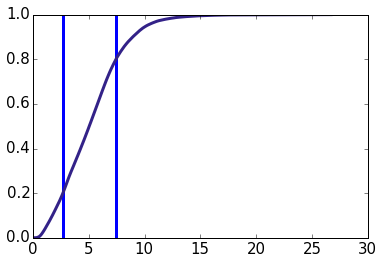

In [152]:
plt.plot(r, np.cumsum(r)/np.sum(r))
plt.axvline(x=r[where_80perc], zorder=-1)
plt.axvline(x=r[where_20perc], zorder=-1)

## Asymmetry

In [153]:
bin_dict = snap.bin_snap()
surface_density = bin_dict['Z2']
centerx = (bin_dict['Z2x'][:-1] + bin_dict['Z2x'][1:]) / 2
centery = (bin_dict['Z2y'][:-1] + bin_dict['Z2y'][1:]) / 2
centerX, centerY = np.meshgrid(centerx, centery, indexing='ij')

In [154]:
A = np.nansum(np.abs(surface_density - np.rot90(surface_density, k=2))/np.nansum(np.abs(surface_density) ))
print "Asymmetry A = {:g}".format(A)

Asymmetry A = 1.0272


## Gini Coefficient

In [155]:
XBar = np.nanmean(surface_density)
sorted_values = np.sort(surface_density.flatten())
n = len(sorted_values)
gini = 1.0/(XBar*n*(n-1))*np.nansum((2.0*np.arange(n)-n-1.0)*sorted_values)
print "Gini coefficient G = {:g}".format(gini)

Gini coefficient G = 0.826168


## M20

In [156]:
good_ind = np.where(np.isfinite(surface_density))
sort_ind = np.argsort(surface_density[good_ind].flatten())[::-1]
xs = centerX[good_ind].flatten()[sort_ind]
ys = centerY[good_ind].flatten()[sort_ind]
sorted_values = surface_density[good_ind].flatten()[sort_ind]

fi = np.cumsum(sorted_values)
ftot = np.sum(sorted_values)

twenty_perc = np.nanargmin(np.abs(fi - 0.2*ftot))
Mi = (sorted_values*((xs - xc)**2 + (ys - yc)**2))
M20 = np.log10(np.sum(Mi[:twenty_perc])/np.sum(Mi))
print "M20 = {:g}".format(M20)

M20 = -2.36608


In [16]:
sim.set_settings(first_only=True,
                 com=True,
                 xlen=10,
                 ylen=10,
                 NBINS=256,
                 in_min=-0.2752,
                 parttype='stars',
                 halo_center_method='tree_halo',
                 log_scale=False)

def measure_conc(snapname, dynamical_centers):
    snap = snapio.load_snap(snapname)
    return snap.measure_concentration(center=dynamical_centers)
 

c_sim = sim.apply_function(measure_conc, dynamical_centers)    

In [167]:
sim.set_settings(first_only=True,
                 com=True,
                 xlen=10,
                 ylen=10,
                 NBINS=256,
                 in_min=-0.2752,
                 parttype='stars',
                 halo_center_method='tree_halo',
                 log_scale=False)

def measure_m20(snapname, dynamical_centers):
    snap = snapio.load_snap(snapname)
    snap.set_settings(**sim.settings)
    return snap.measure_m20(center=dynamical_centers)
 

m20_sim = np.empty(82)
for i in xrange(82):
    snap = snapio.load_snap(folder+"snap_{:03d}".format(i))
    snap.set_settings(first_only=True,
                 com=True,
                 xlen=10,
                 ylen=10,
                 NBINS=256,
                 in_min=-0.2752,
                 parttype='stars',
                 halo_center_method='tree_halo',
                 log_scale=False)
    m20_sim[i] = snap.measure_m20(center=dynamical_centers[i, :])

In [11]:
sim.set_settings(first_only=True,
                 com=True,
                 xlen=10,
                 ylen=10,
                 NBINS=256,
                 in_min=-0.2752,
                 parttype='stars',
                 halo_center_method='tree_halo',
                 log_scale=False)
 
a_sim = np.empty(82)
for i in xrange(82):
    snap = snapio.load_snap(folder+"snap_{:03d}".format(i))
    snap.set_settings(first_only=True,
                 com=True,
                 xlen=10,
                 ylen=10,
                 NBINS=256,
                 in_min=-0.2752,
                 parttype='stars',
                 halo_center_method='tree_halo',
                 log_scale=False)
    a_sim[i] = snap.measure_asymmetry()
    
a_ICsim = np.empty(82)
for i in xrange(82):
    snap = snapio.load_snap(ICfolder+"snap_{:03d}".format(i))
    snap.set_settings(first_only=True,
                 com=True,
                 xlen=10,
                 ylen=10,
                 NBINS=256,
                 in_min=-0.2752,
                 parttype='stars',
                 halo_center_method='tree_halo',
                 log_scale=False)
    a_ICsim[i] = snap.measure_asymmetry()
    
    
a_contsim = np.empty(82)
for i in xrange(82):
    snap = snapio.load_snap(cont_folder+"snap_{:03d}".format(i))
    snap.set_settings(first_only=True,
                 com=True,
                 xlen=10,
                 ylen=10,
                 NBINS=256,
                 in_min=-0.2752,
                 parttype='stars',
                 halo_center_method='tree_halo',
                 log_scale=False)
    a_contsim[i] = snap.measure_asymmetry()

In [229]:

    
gini_ICsim = np.empty(82)
for i in xrange(82):
    snap = snapio.load_snap(ICfolder+"snap_{:03d}".format(i))
    gini_ICsim[i] = gini_petrosian(snap)
    
m20_ICsim = np.empty(82)
for i in xrange(82):
    snap = snapio.load_snap(ICfolder+"snap_{:03d}".format(i))
    m20_ICsim[i] = m20_petrosian(snap, center=IC_dyn_centers[i, :])

    
ICsim.set_settings(first_only=True,
                 com=True,
                 xlen=10,
                 ylen=10,
                 NBINS=256,
                 in_min=-0.2752,
                 parttype='stars',
                 halo_center_method='tree_halo',
                 log_scale=False)
    
c_ICsim = ICsim.apply_function(measure_conc, IC_dyn_centers)  

In [211]:
gini_sim = np.empty(82)
for i in xrange(82):
    snap = snapio.load_snap(folder+"snap_{:03d}".format(i))
    gini_sim[i] = gini_petrosian(snap)


In [218]:
m20_sim = np.empty(82)
for i in xrange(82):
    snap = snapio.load_snap(folder+"snap_{:03d}".format(i))
    m20_sim[i] = m20_petrosian(snap, center=dynamical_centers[i, :])

In [217]:
def m20_petrosian(snap, center=np.array([0, 0, 0])):
    snap.set_settings(first_only=True,
                 com=True,
                 xlen=10,
                 ylen=10,
                 NBINS=256,
                 in_min=-0.2752,
                 parttype='stars',
                 halo_center_method='tree_halo',
                 log_scale=False)

    bin_dict = snap.bin_snap()
    centerx = (bin_dict['Z2x'][:-1] + bin_dict['Z2x'][1:]) / 2
    centery = (bin_dict['Z2y'][:-1] + bin_dict['Z2y'][1:]) / 2
    centerX, centerY = np.meshgrid(centerx, centery, indexing='ij')

    centerR = np.sqrt(centerX**2 + centerY**2)
    rsort = np.argsort(centerR.ravel())
    n = 256
    stat, bin_edges, binnumber = stats.binned_statistic(centerR.ravel()[rsort], bin_dict['Z2'].ravel()[rsort], bins=n)
    avg_brightness = np.cumsum(stat)/(np.arange(n)+1)

    brighter_pixels = np.where(avg_brightness*0.2-stat > 0)[0]
    mu_rp = stat[brighter_pixels[0]]

    surface_density = bin_dict['Z2']

    gal_ind = np.where(surface_density > mu_rp)[0]

    sort_ind = np.argsort(surface_density[gal_ind].ravel())[::-1]
    xs = centerX[gal_ind].ravel()[sort_ind]
    ys = centerY[gal_ind].ravel()[sort_ind]
    sorted_values = surface_density[gal_ind].ravel()[sort_ind]

    fi = np.cumsum(sorted_values)
    ftot = np.sum(sorted_values)

    twenty_perc = np.nanargmin(np.abs(fi - 0.2*ftot))
    Mi = (sorted_values*((xs - center[0])**2 + (ys - center[1])**2))
    M20 = np.log10(np.sum(Mi[:twenty_perc])/np.sum(Mi))
    return M20

In [210]:
def gini_petrosian(snap):
    snap.set_settings(first_only=True,
                 com=True,
                 xlen=10,
                 ylen=10,
                 NBINS=256,
                 in_min=-0.2752,
                 parttype='stars',
                 halo_center_method='tree_halo',
                 log_scale=False)

    bin_dict = snap.bin_snap()
    centerx = (bin_dict['Z2x'][:-1] + bin_dict['Z2x'][1:]) / 2
    centery = (bin_dict['Z2y'][:-1] + bin_dict['Z2y'][1:]) / 2
    centerX, centerY = np.meshgrid(centerx, centery, indexing='ij')

    centerR = np.sqrt(centerX**2 + centerY**2)
    rsort = np.argsort(centerR.ravel())
    n = 256
    stat, bin_edges, binnumber = stats.binned_statistic(centerR.ravel()[rsort], bin_dict['Z2'].ravel()[rsort], bins=n)
    avg_brightness = np.cumsum(stat)/(np.arange(n)+1)

    brighter_pixels = np.where(avg_brightness*0.2 > stat)[0]
    #rp = bin_edges[brighter_pixels[0]]
    mu_rp = stat[brighter_pixels[0]]

    surface_density = bin_dict['Z2']

    gal_pix = surface_density[surface_density > mu_rp]

    XBar = np.nanmean(gal_pix)
    sorted_values = np.sort(gal_pix.flatten())
    n = len(sorted_values)
    gini = 1.0/(XBar*n*(n-1))*np.nansum((2.0*np.arange(n)-n-1.0)*sorted_values)
    return gini

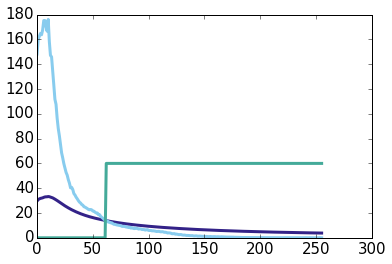

In [241]:
plt.plot(avg_brightness*0.2)
plt.plot(stat)
plt.plot((avg_brightness*0.2 > stat)*60)

In [169]:
def measure_gini(snapname):
    snap = snapio.load_snap(snapname)
    snap.set_settings(**sim.settings)
    return snap.measure_gini()
 
gini_sim = np.empty(82)
for i in xrange(82):
    snap = snapio.load_snap(folder+"snap_{:03d}".format(i))
    snap.set_settings(first_only=True,
                 com=True,
                 xlen=10,
                 ylen=10,
                 NBINS=256,
                 in_min=-0.2752,
                 parttype='stars',
                 halo_center_method='tree_halo',
                 log_scale=False)
    gini_sim[i] = snap.measure_gini()


In [235]:
with h5py.File('../Data/morphologyDehnen.hdf5', 'w') as f:
    subgrp = f.create_group('main')

    dset = subgrp.create_dataset('m20', np.array(m20_sim).shape)
    dset[:] = np.array(m20_sim)

    dset = subgrp.create_dataset('asymmetry', np.array(a_sim).shape)
    dset[:] = np.array(a_sim)

    dset = subgrp.create_dataset('gini', np.array(gini_sim).shape)
    dset[:] = np.array(gini_sim)

    dset = subgrp.create_dataset('concentration', np.array(c_sim).shape)
    dset[:] = np.array(c_sim)

    subgrp = f.create_group('IC')

    dset = subgrp.create_dataset('m20', np.array(m20_ICsim).shape)
    dset[:] = np.array(m20_ICsim)

    dset = subgrp.create_dataset('asymmetry', np.array(a_ICsim).shape)
    dset[:] = np.array(a_ICsim)

    dset = subgrp.create_dataset('gini', np.array(gini_ICsim).shape)
    dset[:] = np.array(gini_ICsim)

    dset = subgrp.create_dataset('concentration', np.array(c_ICsim).shape)
    dset[:] = np.array(c_ICsim)

In [12]:
with h5py.File('../Data/asymmetryDehnen.hdf5', 'w') as f:
    subgrp = f.create_group('main')

    dset = subgrp.create_dataset('asymmetry', np.array(a_sim).shape)
    dset[:] = np.array(a_sim)

    subgrp = f.create_group('IC')

    dset = subgrp.create_dataset('asymmetry', np.array(a_ICsim).shape)
    dset[:] = np.array(a_ICsim)

    subgrp = f.create_group('continue')

    dset = subgrp.create_dataset('asymmetry', np.array(a_contsim).shape)
    dset[:] = np.array(a_contsim)

(0.9, 1.3)

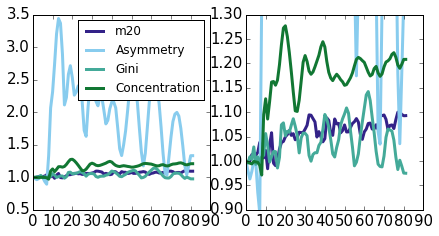

In [220]:
fig, axes = plt.subplots(1,2, figsize=(7, 3.5))

axis = axes[0]
axis.plot(m20_sim/m20_sim[0], label='m20')
axis.plot(a_sim/a_sim[0], label='Asymmetry')
axis.plot(gini_sim/gini_sim[0], label='Gini')
axis.plot(c_sim/c_sim[0], label='Concentration')
axis.legend()


axis = axes[1]
axis.plot(m20_sim/m20_sim[0], label='m20')
axis.plot(a_sim/a_sim[0], label='Asymmetry')
axis.plot(gini_sim/gini_sim[0], label='Gini')
axis.plot(c_sim/c_sim[0], label='Concentration')
axis.set_ylim([0.9, 1.3])

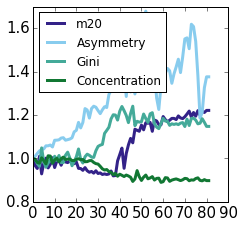

In [234]:
fig, axis = plt.subplots(1, figsize=(3.5, 3.5))

axis.plot(m20_ICsim/m20_ICsim[0], label='m20')
axis.plot(a_ICsim/a_ICsim[0], label='Asymmetry')
axis.plot(gini_ICsim/gini_ICsim[0], label='Gini')
axis.plot(c_ICsim/c_ICsim[0], label='Concentration')
axis.legend(loc='upper left')

